This is a version of the `solution-base` notebook that allows for iterating automatically through multiple settings based on the values in an Excel spreadsheet.

It is recommended that you fully understand `solution-base` before implementing this automated version.

# Imports

In [31]:
%load_ext autoreload
%autoreload 2

import cs7641assn4 as a4
import numpy as np
import pandas as pd
import warnings
import xlrd
from pprint import pprint
import matplotlib.pyplot as plt
pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


--Board--

SFHF
FFFF
FFFF
FFFG

--Actions for Position to the Left of the Goal--
{0: [(0.3333333333333333, 10, -0.1, False),
     (0.3333333333333333, 13, -0.1, False),
     (0.3333333333333333, 14, -0.1, False)],
 1: [(0.3333333333333333, 13, -0.1, False),
     (0.3333333333333333, 14, -0.1, False),
     (0.3333333333333333, 15, 500, True)],
 2: [(0.3333333333333333, 14, -0.1, False),
     (0.3333333333333333, 15, 500, True),
     (0.3333333333333333, 10, -0.1, False)],
 3: [(0.3333333333333333, 15, 500, True),
     (0.3333333333333333, 10, -0.1, False),
     (0.3333333333333333, 13, -0.1, False)]}

--Reward Values at Each State--
-0.1  -0.1  -500  -0.1  
-0.1  -0.1  -0.1  -0.1  
-0.1  -0.1  -0.1  -0.1  
-0.1  -0.1  -0.1   500  

--Value Iteration Values in grid order--
160.649  187.174    -2500  417.692  
254.986  354.455  537.297  731.337  
347.133  537.297  929.448  1474.25  
417.692  731.337  1474.25     2500  

--Value Iteration Policy Matrix--
↓  ←  ←  →  
↓  ↓  ↓  ↓  
↓  →  →  

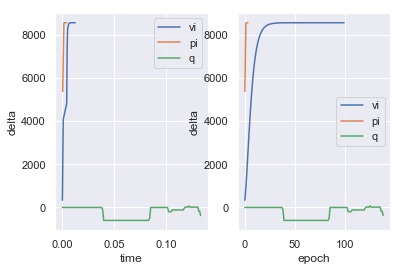

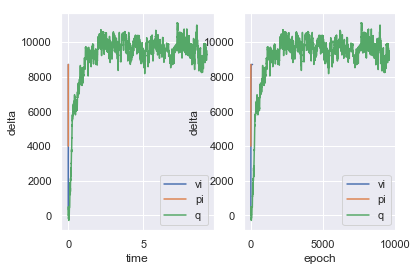

In [54]:
# Import settings, uncomment to read settings from an excel spreadsheet
settings = pd.read_excel('default_settings.xlsx')
settings
results = None

def plot_convergence(vi_epochs, pi_epochs, q_epochs):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(vi_epochs['time'], vi_epochs['delta'], label='vi')
    ax1.plot(pi_epochs['time'], pi_epochs['delta'], label='pi')
    ax1.plot(q_epochs['time'], q_epochs['avg_q'], label='q')
    ax1.set_ylabel('delta')
    ax1.set_xlabel('time')
    ax1.legend()
    
    ax2.plot(vi_epochs.index, vi_epochs['delta'], label='vi')
    ax2.plot(pi_epochs.index, pi_epochs['delta'], label='pi')
    ax2.plot(q_epochs.index, q_epochs['avg_q'], label='q')
    ax2.set_ylabel('delta')
    ax2.set_xlabel('epoch')
    ax2.legend()
    
# Value Iteration
def perform_value_iteration(env, opt, print_arrows=True):    
    vi_V, vi_epochs = a4.valueIteration(env, opt['epsilon'], opt['gamma'], opt['max_iter'], report=opt['report'])

    vi_policy = a4.value_to_policy(env, V=vi_V, gamma=opt['gamma'])
    
    if print_arrows:
        vi_policy_arrows = a4.print_policy(vi_policy, width=opt['size'], height=opt['size'])

    if opt['display_print'] and print_arrows:
        # display value function:
        print('\n--Value Iteration Values in grid order--')
        a4.matprint(a4.print_value(vi_V, width=opt['size'], height=opt['size']))
        
        # display policy
        print('\n--Value Iteration Policy Matrix--')
        a4.matprint(vi_policy_arrows)
    return vi_V, vi_epochs, vi_policy, vi_policy_arrows
        
# Policy Iteration
def perform_policy_iteration(env, opt):
    pi_V, pi_policy, pi_epochs = a4.policy_iteration(env, opt['epsilon'], opt['gamma'], opt['max_iter'], report=opt['report'])
    
    pi_policy_arrows = a4.print_policy(pi_policy, width=opt['size'], height=opt['size'])

    if opt['display_print']:
        # Display values
        print('\n--Policy Iteration Values in grid order--')
        a4.matprint(a4.print_value(pi_V, width=opt['size'], height=opt['size']))

        # Display policy
        print('\n--Policy Iteration Policy Matrix--')
        a4.matprint(pi_policy_arrows)
    return pi_V, pi_epochs, pi_policy, pi_policy_arrows
        
# Q Learning
def perform_q_learning(env, opt):     
    Q, Q_epochs = a4.Qlearning(env, opt['qepsilon'], opt['lr'], opt['qgamma'], opt['max_iter'], opt['episodes'], 
                                     opt['initial'], opt['decay'], report=opt['report'])
    
#     plot_convergence(Q_epochs, opt, 'q')

    maxQ = np.max(Q,axis=1)

    Q_policy = a4.Q_to_policy(Q)

    Q_policy_arrows = a4.print_policy(Q_policy, width=opt['size'], height=opt['size'])

    if opt['display_print']: 
#         print('--Q with all options--')
#         a4.matprint(Q)
        print('\n--argmax(Q) in grid order--')
        a4.matprint(a4.print_value(maxQ, width=opt['size'], height=opt['size']))
        print('\n--Q-Learning Policy Matrix--')
        a4.matprint(Q_policy_arrows)
    return Q, Q_epochs, maxQ, Q_policy, Q_policy_arrows 

# Create Environment
def create_env(opt):

    map_name = 'x'.join([str(opt['size'])]*2) # None, if you want a random map
    env = a4.getEnv(env_id='hw4-FrozenLake-v0', rH=opt['rH'], rG=opt['rG'], rF=opt['rF'], 
                    size=opt['size'],  
                    is_slippery=opt['is_slippery'], render_initial=opt['render_initial'])

    # Store a representation of the map
    env_desc = env.desc.astype('<U8')

    # Store a representation of the state rewards
    env_rs = a4.getStateReward(env)

    if opt['display_print']:
        # Display reward at each state
        print('\n--Reward Values at Each State--')
        a4.matprint(a4.print_value(env_rs, width=opt['size'], height=opt['size']))
    return env, env_desc, env_rs



for i, opt in settings.iterrows():
    
    
    env, env_desc, env_rs = create_env(opt)
    vi_V, vi_epochs, vi_policy, vi_policy_arrows = perform_value_iteration(env, opt)
    pi_V, pi_epochs, pi_policy, pi_policy_arrows = perform_policy_iteration(env, opt)
    Q, Q_epochs, maxQ, Q_policy, Q_policy_arrows  = perform_q_learning(env, opt)
    plot_convergence(vi_epochs, pi_epochs, Q_epochs)
    print(Q_epochs.head())
        
#     ## Save results to DataFrame
#     df = pd.DataFrame({'rH': [opt['rH']], 
#                         'rG': [opt['rG']], 
#                         'rF': [opt['rF']], 
#                         'size': [opt['size']], 
#                         'p': [opt['p']], 
#                         'desc': [env.desc], 
#                         'map_name': [env_desc],                        
#                         'is_slippery': [opt['is_slippery']],
#                         'epsilon': [opt['epsilon']],
#                         'gamma': [opt['gamma']], 
#                         'max_iter': [opt['max_iter']], 
#                         'qepsilon': [opt['qepsilon']], 
#                         'lr': [opt['lr']], 
#                         'qgamma': [opt['qgamma']], 
#                         'episodes': [opt['episodes']], 
#                         'initial': [opt['initial']],
#                         'env_rs': [env_rs],
#                         'pi_V': [pi_V],
#                         'pi_epochs': [pi_epochs],
#                         'pi_policy': [pi_policy],
#                         'pi_policy_arrows': [pi_policy_arrows],
#                         'vi_V': [vi_V],
#                         'vi_epochs': [vi_epochs],
#                         'vi_policy': [vi_policy],
#                         'vi_policy_arrows': [vi_policy_arrows],
#                         'Q': [Q],
#                         'Q_epochs': [Q_epochs],
#                         'Q_V': [maxQ],
#                         'Q_policy': [Q_policy],
#                         'Q_policy_arrows': [Q_policy_arrows]})
    
#     if results is None:
#         results = df
#     else:
#         results.append(df)

    
# if opt['display_print']:
#     display(results)

# ## Save results to disk
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# try:
#     dataset = pd.read_hdf('data.h5', key='dataset', mode='a')
# except FileNotFoundError:
#     results.to_hdf('data.h5', key='dataset', mode='a')
# else:
#     dataset.append(
#         other=results, 
#         ignore_index=True,
#         sort=False
#         ).to_hdf(
#         path_or_buf='data.h5', 
#         key='dataset', 
#         mode='a')

# if opt['display_print']:
#     pd.read_hdf('data.h5', key='dataset', mode='a')
    
    
# print('Complete!')   

# Notes


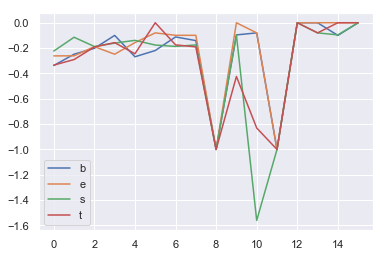

In [50]:
plt.plot(Q)
plt.legend('best')
# pprint(Q)
# print(Q_epochs)
# print([r.max() for r in Q])
# print(np.mean([r.max() for r in Q]))



Default rewards in OpenAI gym Frozen-Lake-v0 are 1 for the G(oal) and 0 for everything else.

Maps are drawn according to the following logic

```
if desc and map_name are None, 
   then a default random map is drawn with 8
        using frozen_lake.generate_random_map(size=8, p=0.8)
elif desc is None and a map_name is given
   then a map_name is either '4x4' or '8x8'
        and is drawn from the dict MAPS in frozen_lake.py
elif desc is given
   then it must be in the form of a list with 
```

Default action probabilities are 1/3 chosen action, 1/3 each for right angles to chosen action, and 0 for reverse of chosen action. This is set with `is_slippery=True`. If `is_slippery=False`, then P=1 for chosen action and 0 for all other actions.

|ACTION|Value|Symbol|
|------|-----|------|
|LEFT  | 0   | ←    |
|DOWN  | 1   | ↓    |
|RIGHT | 2   | →    |
|UP    | 3   | ↑    |

In [47]:
import gym

taxi = gym.make("Taxi-v2").env

taxi.render()
perform_value_iteration(env2, opt, False)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Value iteration converged after  59 epochs


UnboundLocalError: local variable 'vi_policy_arrows' referenced before assignment

# Sources

- Environment: <https://gym.openai.com/envs/FrozenLake-v0/>
- Code: <https://github.com/Twice22/HandsOnRL>
- Tutorial: <https://twice22.github.io/>